# 🧹 Preprocesamiento de Datos
## Fraud Detector para Transacciones Bancarias

Este notebook se enfoca en la limpieza básica de datos, balanceo de clases con SMOTE y división en conjuntos de entrenamiento, validación y prueba.

**Objetivos:**
- Realizar limpieza básica de datos
- Aplicar SMOTE para balancear las clases
- Dividir los datos en conjuntos de entrenamiento, validación y prueba
- Guardar los datos procesados para su uso posterior

**Nota**: La normalización se manejará posteriormente mediante ColumnTransformer en el pipeline de modelado.

## 1. Importación de Librerías

In [1]:
# Manipulación de datos
import pandas as pd
import numpy as np

# División de datos y balanceo
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Utilidades
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

# Configuración
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Semilla para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("📚 Librerías importadas exitosamente!")
print(f"🎲 Semilla aleatoria establecida: {RANDOM_STATE}")

📚 Librerías importadas exitosamente!
🎲 Semilla aleatoria establecida: 42


## 2. Carga de Datos

In [2]:
# Cargar el dataset
try:
    df = pd.read_csv('../data/raw/creditcard.csv')
    print("✅ Dataset cargado exitosamente!")
    print(f"📊 Dimensiones del dataset: {df.shape}")
except FileNotFoundError:
    print("❌ Error: No se encontró el archivo 'creditcard.csv' en '../data/raw/'")
    print("📥 Por favor, descarga el dataset desde Kaggle y colócalo en la carpeta 'data/raw/'")
    print("🔗 Link: https://www.kaggle.com/mlg-ulb/creditcardfraud")
    raise

✅ Dataset cargado exitosamente!
📊 Dimensiones del dataset: (284807, 31)


In [3]:
# Información inicial del dataset
print("📋 INFORMACIÓN INICIAL DEL DATASET")
print("=" * 40)
print(f"Número de filas: {df.shape[0]:,}")
print(f"Número de columnas: {df.shape[1]}")
print(f"Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Distribución inicial de clases
class_distribution = df['Class'].value_counts()
class_percentage = df['Class'].value_counts(normalize=True) * 100

print("\n🎯 Distribución inicial de clases:")
print(f"No Fraude (0): {class_distribution[0]:,} ({class_percentage[0]:.3f}%)")
print(f"Fraude (1): {class_distribution[1]:,} ({class_percentage[1]:.3f}%)")
print(f"Ratio de desbalance: {class_distribution[0]/class_distribution[1]:.1f}:1")

📋 INFORMACIÓN INICIAL DEL DATASET
Número de filas: 284,807
Número de columnas: 31
Memoria utilizada: 67.36 MB

🎯 Distribución inicial de clases:
No Fraude (0): 284,315 (99.827%)
Fraude (1): 492 (0.173%)
Ratio de desbalance: 577.9:1


## 3. Limpieza Básica de Datos

In [4]:
# Verificar calidad de los datos
print("🧹 LIMPIEZA BÁSICA DE DATOS")
print("=" * 30)

# 1. Verificar valores faltantes
missing_values = df.isnull().sum()
print("❓ Valores faltantes por columna:")
if missing_values.sum() == 0:
    print("✅ No hay valores faltantes")
else:
    print(missing_values[missing_values > 0])

# 2. Verificar duplicados
duplicated_rows = df.duplicated().sum()
print(f"\n🔄 Filas duplicadas: {duplicated_rows}")
if duplicated_rows > 0:
    print(f"📊 Porcentaje de duplicados: {duplicated_rows/len(df)*100:.2f}%")

# 3. Verificar tipos de datos
print("\n📊 Tipos de datos:")
print(df.dtypes.value_counts())

# 4. Verificar valores infinitos
inf_values = np.isinf(df.select_dtypes(include=[np.number])).sum().sum()
print(f"\n♾️ Valores infinitos: {inf_values}")

🧹 LIMPIEZA BÁSICA DE DATOS
❓ Valores faltantes por columna:
✅ No hay valores faltantes

🔄 Filas duplicadas: 1081
📊 Porcentaje de duplicados: 0.38%

📊 Tipos de datos:
float64    30
int64       1
Name: count, dtype: int64

♾️ Valores infinitos: 0

🔄 Filas duplicadas: 1081
📊 Porcentaje de duplicados: 0.38%

📊 Tipos de datos:
float64    30
int64       1
Name: count, dtype: int64

♾️ Valores infinitos: 0


In [5]:
# Realizar limpieza si es necesaria
df_clean = df.copy()
initial_rows = len(df_clean)

print("🔧 APLICANDO LIMPIEZA")
print("=" * 25)

# Eliminar duplicados si existen
if duplicated_rows > 0:
    df_clean = df_clean.drop_duplicates()
    print(f"✅ Eliminados {duplicated_rows} duplicados")

# Eliminar filas con valores faltantes si existen
if missing_values.sum() > 0:
    df_clean = df_clean.dropna()
    print(f"✅ Eliminadas {missing_values.sum()} filas con valores faltantes")

# Verificar que no hay valores negativos en Time y Amount (no deberían haberlos)
negative_time = (df_clean['Time'] < 0).sum()
negative_amount = (df_clean['Amount'] < 0).sum()

print(f"\n🔍 Verificaciones adicionales:")
print(f"   Time negativos: {negative_time}")
print(f"   Amount negativos: {negative_amount}")

if negative_time > 0 or negative_amount > 0:
    print("⚠️ Se encontraron valores negativos inesperados")
    # En un caso real, investigaríamos estos valores
    df_clean = df_clean[(df_clean['Time'] >= 0) & (df_clean['Amount'] >= 0)]
    print("✅ Valores negativos eliminados")

final_rows = len(df_clean)
rows_removed = initial_rows - final_rows

print(f"\n📊 Resumen de limpieza:")
print(f"   Filas iniciales: {initial_rows:,}")
print(f"   Filas finales: {final_rows:,}")
print(f"   Filas eliminadas: {rows_removed:,} ({rows_removed/initial_rows*100:.2f}%)")

if rows_removed == 0:
    print("✅ No se requirió limpieza adicional - datos de alta calidad")

🔧 APLICANDO LIMPIEZA
✅ Eliminados 1081 duplicados

🔍 Verificaciones adicionales:
   Time negativos: 0
   Amount negativos: 0

📊 Resumen de limpieza:
   Filas iniciales: 284,807
   Filas finales: 283,726
   Filas eliminadas: 1,081 (0.38%)
✅ Eliminados 1081 duplicados

🔍 Verificaciones adicionales:
   Time negativos: 0
   Amount negativos: 0

📊 Resumen de limpieza:
   Filas iniciales: 284,807
   Filas finales: 283,726
   Filas eliminadas: 1,081 (0.38%)


📈 DISTRIBUCIÓN DESPUÉS DE LA LIMPIEZA
🎯 Nueva distribución de clases:
No Fraude (0): 283,253 (99.833%)
Fraude (1): 473 (0.167%)
Nuevo ratio de desbalance: 598.8:1


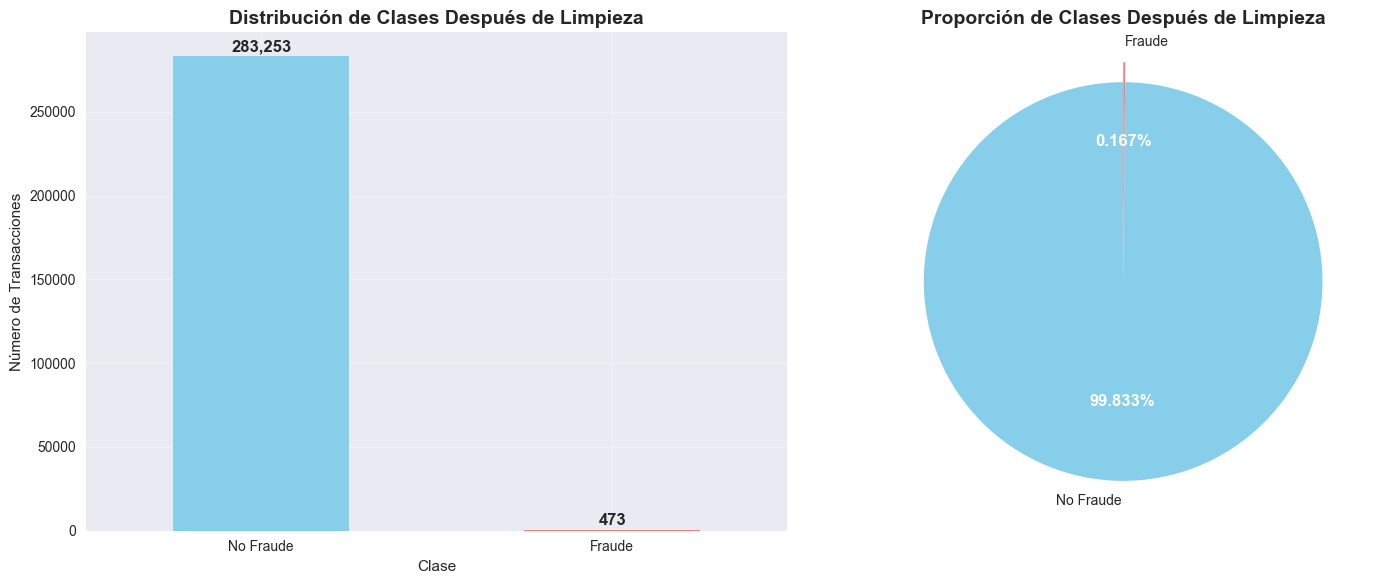

In [6]:
# Verificar distribución después de la limpieza
print("📈 DISTRIBUCIÓN DESPUÉS DE LA LIMPIEZA")
print("=" * 40)

class_distribution_clean = df_clean['Class'].value_counts()
class_percentage_clean = df_clean['Class'].value_counts(normalize=True) * 100

print("🎯 Nueva distribución de clases:")
print(f"No Fraude (0): {class_distribution_clean[0]:,} ({class_percentage_clean[0]:.3f}%)")
print(f"Fraude (1): {class_distribution_clean[1]:,} ({class_percentage_clean[1]:.3f}%)")
print(f"Nuevo ratio de desbalance: {class_distribution_clean[0]/class_distribution_clean[1]:.1f}:1")

# Visualizar la distribución
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de barras
class_distribution_clean.plot(kind='bar', ax=axes[0], color=['skyblue', 'lightcoral'])
axes[0].set_title('Distribución de Clases Después de Limpieza', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Clase')
axes[0].set_ylabel('Número de Transacciones')
axes[0].set_xticklabels(['No Fraude', 'Fraude'], rotation=0)
axes[0].grid(True, alpha=0.3)

# Agregar valores en las barras
for i, v in enumerate(class_distribution_clean.values):
    axes[0].text(i, v + 1000, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Gráfico de pastel
colors = ['skyblue', 'lightcoral']
wedges, texts, autotexts = axes[1].pie(class_distribution_clean.values, 
                                       labels=['No Fraude', 'Fraude'],
                                       autopct='%1.3f%%',
                                       colors=colors,
                                       startangle=90,
                                       explode=(0, 0.1))
axes[1].set_title('Proporción de Clases Después de Limpieza', fontsize=14, fontweight='bold')

# Mejorar el texto del gráfico de pastel
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

## 4. División Inicial de Datos

In [7]:
# Separar características y variable objetivo
print("🎯 PREPARACIÓN PARA DIVISIÓN DE DATOS")
print("=" * 40)

# Definir características (X) y variable objetivo (y)
X = df_clean.drop('Class', axis=1)
y = df_clean['Class']

print(f"📊 Dimensiones de características (X): {X.shape}")
print(f"📊 Dimensiones de variable objetivo (y): {y.shape}")
print(f"\n📋 Columnas de características:")
print(f"   Total: {len(X.columns)}")
print(f"   Variables PCA: {len([col for col in X.columns if col.startswith('V')])}")
print(f"   Variables originales: Time, Amount")

# Verificar distribución de la variable objetivo
print(f"\n🎯 Distribución de variable objetivo:")
print(f"   Clase 0 (No Fraude): {(y == 0).sum():,}")
print(f"   Clase 1 (Fraude): {(y == 1).sum():,}")

🎯 PREPARACIÓN PARA DIVISIÓN DE DATOS
📊 Dimensiones de características (X): (283726, 30)
📊 Dimensiones de variable objetivo (y): (283726,)

📋 Columnas de características:
   Total: 30
   Variables PCA: 28
   Variables originales: Time, Amount

🎯 Distribución de variable objetivo:
   Clase 0 (No Fraude): 283,253
   Clase 1 (Fraude): 473


In [8]:
# Primera división: separar conjunto de prueba (test)
print("🔄 DIVISIÓN INICIAL: ENTRENAMIENTO + VALIDACIÓN vs PRUEBA")
print("=" * 60)

# Dividir en 80% (train+val) y 20% (test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y  # Mantener la proporción de clases
)

print(f"📊 Conjunto temporal (train+val): {X_temp.shape[0]:,} muestras")
print(f"📊 Conjunto de prueba: {X_test.shape[0]:,} muestras")

# Verificar distribución en conjunto de prueba
test_distribution = y_test.value_counts()
print(f"\n🎯 Distribución en conjunto de prueba:")
print(f"   No Fraude: {test_distribution[0]:,} ({test_distribution[0]/len(y_test)*100:.3f}%)")
print(f"   Fraude: {test_distribution[1]:,} ({test_distribution[1]/len(y_test)*100:.3f}%)")

🔄 DIVISIÓN INICIAL: ENTRENAMIENTO + VALIDACIÓN vs PRUEBA
📊 Conjunto temporal (train+val): 226,980 muestras
📊 Conjunto de prueba: 56,746 muestras

🎯 Distribución en conjunto de prueba:
   No Fraude: 56,651 (99.833%)
   Fraude: 95 (0.167%)


In [9]:
# Segunda división: separar entrenamiento y validación
print("🔄 DIVISIÓN FINAL: ENTRENAMIENTO vs VALIDACIÓN")
print("=" * 45)

# Dividir el conjunto temporal en 75% (train) y 25% (val)
# Esto resulta en aproximadamente 60% train, 20% val, 20% test del total
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.25, 
    random_state=RANDOM_STATE, 
    stratify=y_temp
)

print(f"📊 Conjunto de entrenamiento: {X_train.shape[0]:,} muestras")
print(f"📊 Conjunto de validación: {X_val.shape[0]:,} muestras")
print(f"📊 Conjunto de prueba: {X_test.shape[0]:,} muestras")

# Calcular porcentajes del total
total_samples = len(df_clean)
train_pct = len(X_train) / total_samples * 100
val_pct = len(X_val) / total_samples * 100
test_pct = len(X_test) / total_samples * 100

print(f"\n📈 Porcentajes del dataset total:")
print(f"   Entrenamiento: {train_pct:.1f}%")
print(f"   Validación: {val_pct:.1f}%")
print(f"   Prueba: {test_pct:.1f}%")

# Verificar distribución de clases en cada conjunto
print(f"\n🎯 Distribución de clases por conjunto:")
for name, y_subset in [('Entrenamiento', y_train), ('Validación', y_val), ('Prueba', y_test)]:
    dist = y_subset.value_counts()
    fraud_pct = dist[1] / len(y_subset) * 100
    print(f"   {name}: {dist[0]:,} no fraude, {dist[1]:,} fraude ({fraud_pct:.3f}% fraude)")

🔄 DIVISIÓN FINAL: ENTRENAMIENTO vs VALIDACIÓN
📊 Conjunto de entrenamiento: 170,235 muestras
📊 Conjunto de validación: 56,745 muestras
📊 Conjunto de prueba: 56,746 muestras

📈 Porcentajes del dataset total:
   Entrenamiento: 60.0%
   Validación: 20.0%
   Prueba: 20.0%

🎯 Distribución de clases por conjunto:
   Entrenamiento: 169,951 no fraude, 284 fraude (0.167% fraude)
   Validación: 56,651 no fraude, 94 fraude (0.166% fraude)
   Prueba: 56,651 no fraude, 95 fraude (0.167% fraude)
📊 Conjunto de entrenamiento: 170,235 muestras
📊 Conjunto de validación: 56,745 muestras
📊 Conjunto de prueba: 56,746 muestras

📈 Porcentajes del dataset total:
   Entrenamiento: 60.0%
   Validación: 20.0%
   Prueba: 20.0%

🎯 Distribución de clases por conjunto:
   Entrenamiento: 169,951 no fraude, 284 fraude (0.167% fraude)
   Validación: 56,651 no fraude, 94 fraude (0.166% fraude)
   Prueba: 56,651 no fraude, 95 fraude (0.167% fraude)


## 5. Aplicación de SMOTE para Balanceo de Clases

In [10]:
# Verificar distribución antes de SMOTE
print("⚖️ BALANCEO DE CLASES CON SMOTE")
print("=" * 35)

print("📊 Distribución ANTES de SMOTE (conjunto de entrenamiento):")
train_distribution_before = Counter(y_train)
print(f"   No Fraude (0): {train_distribution_before[0]:,}")
print(f"   Fraude (1): {train_distribution_before[1]:,}")
print(f"   Ratio: {train_distribution_before[0]/train_distribution_before[1]:.1f}:1")
print(f"   Total muestras: {len(y_train):,}")

⚖️ BALANCEO DE CLASES CON SMOTE
📊 Distribución ANTES de SMOTE (conjunto de entrenamiento):
   No Fraude (0): 169,951
   Fraude (1): 284
   Ratio: 598.4:1
   Total muestras: 170,235


In [11]:
# Aplicar SMOTE solo al conjunto de entrenamiento
print("🔄 Aplicando SMOTE...")

# Configurar SMOTE
smote = SMOTE(
    random_state=RANDOM_STATE,
    k_neighbors=5,  # Número de vecinos más cercanos
    sampling_strategy='auto'  # Balancear automáticamente a 1:1
)

# Aplicar SMOTE
try:
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    print("✅ SMOTE aplicado exitosamente!")
except Exception as e:
    print(f"❌ Error al aplicar SMOTE: {e}")
    raise

# Verificar distribución después de SMOTE
print("\n📊 Distribución DESPUÉS de SMOTE (conjunto de entrenamiento):")
train_distribution_after = Counter(y_train_balanced)
print(f"   No Fraude (0): {train_distribution_after[0]:,}")
print(f"   Fraude (1): {train_distribution_after[1]:,}")
print(f"   Ratio: {train_distribution_after[0]/train_distribution_after[1]:.1f}:1")
print(f"   Total muestras: {len(y_train_balanced):,}")

# Calcular incremento
samples_added = len(y_train_balanced) - len(y_train)
fraud_samples_added = train_distribution_after[1] - train_distribution_before[1]
print(f"\n📈 Muestras sintéticas generadas:")
print(f"   Total nuevas muestras: {samples_added:,}")
print(f"   Muestras de fraude sintéticas: {fraud_samples_added:,}")
print(f"   Incremento en tamaño: {samples_added/len(y_train)*100:.1f}%")

🔄 Aplicando SMOTE...
✅ SMOTE aplicado exitosamente!

📊 Distribución DESPUÉS de SMOTE (conjunto de entrenamiento):
   No Fraude (0): 169,951
   Fraude (1): 169,951
   Ratio: 1.0:1
   Total muestras: 339,902

📈 Muestras sintéticas generadas:
   Total nuevas muestras: 169,667
   Muestras de fraude sintéticas: 169,667
   Incremento en tamaño: 99.7%
✅ SMOTE aplicado exitosamente!

📊 Distribución DESPUÉS de SMOTE (conjunto de entrenamiento):
   No Fraude (0): 169,951
   Fraude (1): 169,951
   Ratio: 1.0:1
   Total muestras: 339,902

📈 Muestras sintéticas generadas:
   Total nuevas muestras: 169,667
   Muestras de fraude sintéticas: 169,667
   Incremento en tamaño: 99.7%


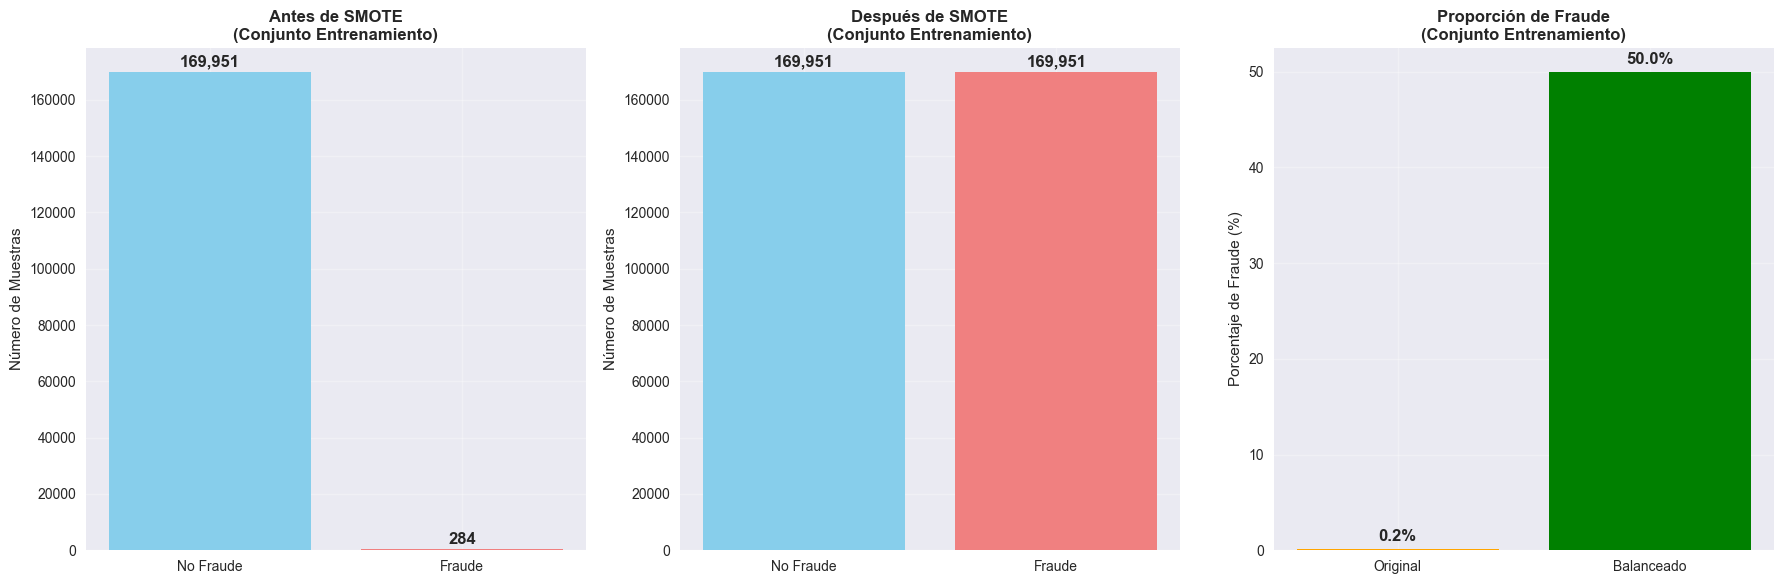


💡 Observaciones:
   • SMOTE se aplicó SOLO al conjunto de entrenamiento
   • Los conjuntos de validación y prueba mantienen su distribución original
   • Esto evita data leakage y permite evaluación realista


In [12]:
# Visualizar el efecto del balanceo
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Distribución original
original_counts = [train_distribution_before[0], train_distribution_before[1]]
axes[0].bar(['No Fraude', 'Fraude'], original_counts, color=['skyblue', 'lightcoral'])
axes[0].set_title('Antes de SMOTE\n(Conjunto Entrenamiento)', fontweight='bold')
axes[0].set_ylabel('Número de Muestras')
axes[0].grid(True, alpha=0.3)
for i, v in enumerate(original_counts):
    axes[0].text(i, v + 1000, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Distribución después de SMOTE
balanced_counts = [train_distribution_after[0], train_distribution_after[1]]
axes[1].bar(['No Fraude', 'Fraude'], balanced_counts, color=['skyblue', 'lightcoral'])
axes[1].set_title('Después de SMOTE\n(Conjunto Entrenamiento)', fontweight='bold')
axes[1].set_ylabel('Número de Muestras')
axes[1].grid(True, alpha=0.3)
for i, v in enumerate(balanced_counts):
    axes[1].text(i, v + 1000, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Comparación de proporciones
labels = ['Original', 'Balanceado']
fraud_proportions = [
    train_distribution_before[1] / sum(train_distribution_before.values()) * 100,
    train_distribution_after[1] / sum(train_distribution_after.values()) * 100
]
axes[2].bar(labels, fraud_proportions, color=['orange', 'green'])
axes[2].set_title('Proporción de Fraude\n(Conjunto Entrenamiento)', fontweight='bold')
axes[2].set_ylabel('Porcentaje de Fraude (%)')
axes[2].grid(True, alpha=0.3)
for i, v in enumerate(fraud_proportions):
    axes[2].text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 Observaciones:")
print("   • SMOTE se aplicó SOLO al conjunto de entrenamiento")
print("   • Los conjuntos de validación y prueba mantienen su distribución original")
print("   • Esto evita data leakage y permite evaluación realista")

## 6. Verificación de Datos Balanceados

In [13]:
# Verificar que las dimensiones son correctas
print("✅ VERIFICACIÓN DE DATOS PROCESADOS")
print("=" * 40)

print("📊 Dimensiones finales de los conjuntos:")
print(f"   X_train_balanced: {X_train_balanced.shape}")
print(f"   y_train_balanced: {y_train_balanced.shape}")
print(f"   X_val: {X_val.shape}")
print(f"   y_val: {y_val.shape}")
print(f"   X_test: {X_test.shape}")
print(f"   y_test: {y_test.shape}")

# Verificar que no hay valores faltantes en los conjuntos procesados
print(f"\n🔍 Verificación de calidad:")
print(f"   X_train_balanced - NaN: {X_train_balanced.isnull().sum().sum()}")
print(f"   X_val - NaN: {X_val.isnull().sum().sum()}")
print(f"   X_test - NaN: {X_test.isnull().sum().sum()}")

# Verificar rango de valores de las características principales
print(f"\n📈 Rangos de características principales (entrenamiento balanceado):")
for col in ['Time', 'Amount']:
    min_val = X_train_balanced[col].min()
    max_val = X_train_balanced[col].max()
    mean_val = X_train_balanced[col].mean()
    print(f"   {col}: [{min_val:.2f}, {max_val:.2f}] (media: {mean_val:.2f})")

# Resumen de características únicas
print(f"\n📋 Características disponibles:")
pca_features = [col for col in X_train_balanced.columns if col.startswith('V')]
other_features = [col for col in X_train_balanced.columns if not col.startswith('V')]
print(f"   Características PCA: {len(pca_features)} (V1 a V28)")
print(f"   Otras características: {len(other_features)} ({', '.join(other_features)})")
print(f"   Total características: {X_train_balanced.shape[1]}")

✅ VERIFICACIÓN DE DATOS PROCESADOS
📊 Dimensiones finales de los conjuntos:
   X_train_balanced: (339902, 30)
   y_train_balanced: (339902,)
   X_val: (56745, 30)
   y_val: (56745,)
   X_test: (56746, 30)
   y_test: (56746,)

🔍 Verificación de calidad:
   X_train_balanced - NaN: 0
   X_val - NaN: 0
   X_test - NaN: 0

📈 Rangos de características principales (entrenamiento balanceado):
   Time: [0.00, 172788.00] (media: 88426.01)
   Amount: [0.00, 19656.53] (media: 98.54)

📋 Características disponibles:
   Características PCA: 28 (V1 a V28)
   Otras características: 2 (Time, Amount)
   Total características: 30


## 7. Guardado de Datos Procesados

In [14]:
# Crear directorio de datos procesados si no existe
processed_dir = '../data/processed/'
os.makedirs(processed_dir, exist_ok=True)

print("💾 GUARDANDO DATOS PROCESADOS")
print("=" * 35)

# Guardar conjuntos de datos como CSV
datasets_to_save = {
    'X_train_balanced.csv': X_train_balanced,
    'y_train_balanced.csv': y_train_balanced,
    'X_val.csv': X_val,
    'y_val.csv': y_val,
    'X_test.csv': X_test,
    'y_test.csv': y_test
}

for filename, data in datasets_to_save.items():
    filepath = os.path.join(processed_dir, filename)
    if isinstance(data, pd.Series):
        data.to_csv(filepath, index=False, header=['Class'])
    else:
        data.to_csv(filepath, index=False)
    print(f"✅ Guardado: {filename} - Forma: {data.shape}")

# Guardar también información del procesamiento
processing_info = {
    'random_state': RANDOM_STATE,
    'original_shape': df.shape,
    'cleaned_shape': df_clean.shape,
    'train_original_distribution': dict(train_distribution_before),
    'train_balanced_distribution': dict(train_distribution_after),
    'smote_config': {
        'k_neighbors': 5,
        'sampling_strategy': 'auto'
    },
    'split_ratios': {
        'train': train_pct,
        'val': val_pct,
        'test': test_pct
    }
}

# Guardar información de procesamiento
import json
info_path = os.path.join(processed_dir, 'processing_info.json')
with open(info_path, 'w') as f:
    json.dump(processing_info, f, indent=2)
print(f"✅ Guardado: processing_info.json")

print(f"\n📁 Todos los archivos guardados en: {processed_dir}")
print(f"📋 Archivos creados: {len(datasets_to_save) + 1}")

💾 GUARDANDO DATOS PROCESADOS
✅ Guardado: X_train_balanced.csv - Forma: (339902, 30)
✅ Guardado: y_train_balanced.csv - Forma: (339902,)
✅ Guardado: X_train_balanced.csv - Forma: (339902, 30)
✅ Guardado: y_train_balanced.csv - Forma: (339902,)
✅ Guardado: X_val.csv - Forma: (56745, 30)
✅ Guardado: y_val.csv - Forma: (56745,)
✅ Guardado: X_val.csv - Forma: (56745, 30)
✅ Guardado: y_val.csv - Forma: (56745,)
✅ Guardado: X_test.csv - Forma: (56746, 30)
✅ Guardado: y_test.csv - Forma: (56746,)
✅ Guardado: processing_info.json

📁 Todos los archivos guardados en: ../data/processed/
📋 Archivos creados: 7
✅ Guardado: X_test.csv - Forma: (56746, 30)
✅ Guardado: y_test.csv - Forma: (56746,)
✅ Guardado: processing_info.json

📁 Todos los archivos guardados en: ../data/processed/
📋 Archivos creados: 7


In [15]:
# Verificar que los archivos se guardaron correctamente
print("🔍 VERIFICACIÓN DE ARCHIVOS GUARDADOS")
print("=" * 40)

import os
saved_files = os.listdir(processed_dir)
saved_files.sort()

print("📁 Archivos en data/processed/:")
for file in saved_files:
    filepath = os.path.join(processed_dir, file)
    if file.endswith('.csv'):
        # Leer para verificar dimensiones
        temp_df = pd.read_csv(filepath)
        size_mb = os.path.getsize(filepath) / 1024**2
        print(f"   📄 {file}: {temp_df.shape} ({size_mb:.1f} MB)")
    elif file.endswith('.json'):
        size_kb = os.path.getsize(filepath) / 1024
        print(f"   📄 {file}: ({size_kb:.1f} KB)")

# Calcular espacio total utilizado
total_size = sum(os.path.getsize(os.path.join(processed_dir, f)) for f in saved_files)
print(f"\n💾 Espacio total utilizado: {total_size / 1024**2:.1f} MB")

🔍 VERIFICACIÓN DE ARCHIVOS GUARDADOS
📁 Archivos en data/processed/:
   📄 X_test.csv: (56746, 30) (28.5 MB)
   📄 X_test.csv: (56746, 30) (28.5 MB)
   📄 X_train_balanced.csv: (339902, 30) (179.3 MB)
   📄 X_train_balanced.csv: (339902, 30) (179.3 MB)
   📄 X_val.csv: (56745, 30) (28.6 MB)
   📄 processing_info.json: (0.4 KB)
   📄 y_test.csv: (56746, 1) (0.1 MB)
   📄 y_train_balanced.csv: (339902, 1) (0.6 MB)
   📄 y_val.csv: (56745, 1) (0.1 MB)

💾 Espacio total utilizado: 237.3 MB
   📄 X_val.csv: (56745, 30) (28.6 MB)
   📄 processing_info.json: (0.4 KB)
   📄 y_test.csv: (56746, 1) (0.1 MB)
   📄 y_train_balanced.csv: (339902, 1) (0.6 MB)
   📄 y_val.csv: (56745, 1) (0.1 MB)

💾 Espacio total utilizado: 237.3 MB


## 8. Resumen del Preprocesamiento

In [16]:
# Resumen completo del preprocesamiento
print("📋 RESUMEN DEL PREPROCESAMIENTO")
print("=" * 40)

print("🧹 LIMPIEZA DE DATOS:")
print(f"   • Dataset original: {df.shape[0]:,} filas × {df.shape[1]} columnas")
print(f"   • Dataset limpio: {df_clean.shape[0]:,} filas × {df_clean.shape[1]} columnas")
print(f"   • Filas eliminadas: {df.shape[0] - df_clean.shape[0]:,}")
print(f"   • Calidad: Sin valores faltantes, sin duplicados")

print(f"\n📊 DIVISIÓN DE DATOS:")
print(f"   • Entrenamiento: {X_train.shape[0]:,} muestras ({train_pct:.1f}%)")
print(f"   • Validación: {X_val.shape[0]:,} muestras ({val_pct:.1f}%)")
print(f"   • Prueba: {X_test.shape[0]:,} muestras ({test_pct:.1f}%)")
print(f"   • División estratificada: Proporciones de fraude conservadas")

print(f"\n⚖️ BALANCEO CON SMOTE:")
print(f"   • Aplicado solo a conjunto de entrenamiento")
print(f"   • Antes: {train_distribution_before[0]:,} vs {train_distribution_before[1]:,} (ratio {train_distribution_before[0]/train_distribution_before[1]:.1f}:1)")
print(f"   • Después: {train_distribution_after[0]:,} vs {train_distribution_after[1]:,} (ratio 1:1)")
print(f"   • Muestras sintéticas generadas: {fraud_samples_added:,}")

print(f"\n📋 CARACTERÍSTICAS:")
print(f"   • Total de características: {X_train_balanced.shape[1]}")
print(f"   • Variables PCA: {len(pca_features)} (V1-V28)")
print(f"   • Variables originales: 2 (Time, Amount)")
print(f"   • Variable objetivo: Class (0=No Fraude, 1=Fraude)")

print(f"\n💾 ARCHIVOS GENERADOS:")
print(f"   • X_train_balanced.csv: {X_train_balanced.shape}")
print(f"   • y_train_balanced.csv: {y_train_balanced.shape}")
print(f"   • X_val.csv: {X_val.shape}")
print(f"   • y_val.csv: {y_val.shape}")
print(f"   • X_test.csv: {X_test.shape}")
print(f"   • y_test.csv: {y_test.shape}")
print(f"   • processing_info.json: Metadatos del procesamiento")

print(f"\n✅ ESTADO:")
print(f"   • Datos listos para modelado")
print(f"   • Normalización pendiente (se hará en pipeline)")
print(f"   • Feature engineering pendiente (opcional)")
print(f"   • Conjuntos balanceados y separados correctamente")

print(f"\n🎯 PRÓXIMOS PASOS:")
print(f"   • Crear pipelines de preprocessing con ColumnTransformer")
print(f"   • Entrenar modelos: Logistic Regression, Random Forest, XGBoost, LightGBM")
print(f"   • Evaluar con métricas apropiadas: Precision, Recall, F1, ROC-AUC")
print(f"   • Aplicar SHAP para interpretabilidad")

print("\n" + "=" * 40)
print("🎉 PREPROCESAMIENTO COMPLETADO EXITOSAMENTE")
print("=" * 40)

📋 RESUMEN DEL PREPROCESAMIENTO
🧹 LIMPIEZA DE DATOS:
   • Dataset original: 284,807 filas × 31 columnas
   • Dataset limpio: 283,726 filas × 31 columnas
   • Filas eliminadas: 1,081
   • Calidad: Sin valores faltantes, sin duplicados

📊 DIVISIÓN DE DATOS:
   • Entrenamiento: 170,235 muestras (60.0%)
   • Validación: 56,745 muestras (20.0%)
   • Prueba: 56,746 muestras (20.0%)
   • División estratificada: Proporciones de fraude conservadas

⚖️ BALANCEO CON SMOTE:
   • Aplicado solo a conjunto de entrenamiento
   • Antes: 169,951 vs 284 (ratio 598.4:1)
   • Después: 169,951 vs 169,951 (ratio 1:1)
   • Muestras sintéticas generadas: 169,667

📋 CARACTERÍSTICAS:
   • Total de características: 30
   • Variables PCA: 28 (V1-V28)
   • Variables originales: 2 (Time, Amount)
   • Variable objetivo: Class (0=No Fraude, 1=Fraude)

💾 ARCHIVOS GENERADOS:
   • X_train_balanced.csv: (339902, 30)
   • y_train_balanced.csv: (339902,)
   • X_val.csv: (56745, 30)
   • y_val.csv: (56745,)
   • X_test.csv: (